In [1]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
dataset = datasets.ImageFolder('data/', transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

brain_staining
cervix_staining


In [8]:
# Load pretrained model
model = models.resnet50(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer for feature extraction
model.fc = nn.Identity()

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\samue/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 10.3MB/s]


In [9]:
def extract_features(dataloader, model):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            features.append(outputs)
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)

features, labels = extract_features(dataloader, model)

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
transformed = tsne.fit_transform(features)


c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


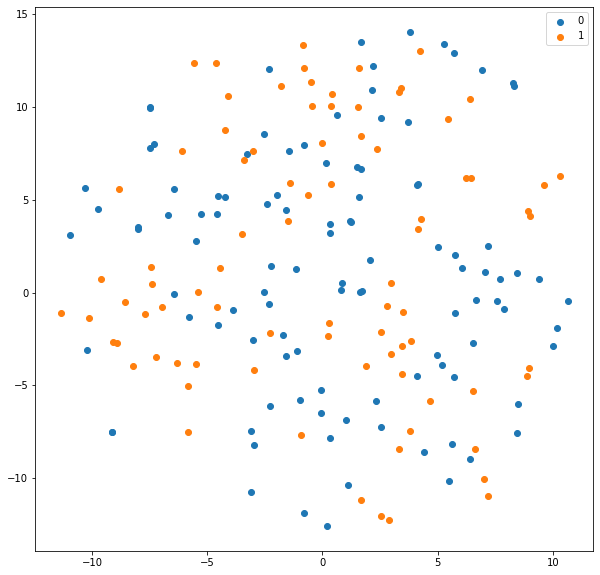

In [14]:
# Plot reduced features
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
# plt points with label 0
mask = labels == 0
plt.scatter(transformed[mask, 0], transformed[mask, 1], label='0')
# plt points with label 1
mask = labels == 1
plt.scatter(transformed[mask, 0], transformed[mask, 1], label='1')
plt.legend()
plt.show()
